# Max-Cut Demonstration using Dirac-1
## Background
The Maximal Cut (max-cut) problem is a well known NP-hard problem in combinatorial optimization used in quantum computing demonstrations due to its efficient, natural formulation as a QUBO or Ising Hamiltonian. The goal of the problem is to separate the nodes of a graph into two subsets where the number of edges between the two sets is maximal. This is a maximal cut. 
## Contents
The demo uses the 320 node instance from [QED-C QC-App-Oriented-Benchmarks Max Cut](https://github.com/SRI-International/QC-App-Oriented-Benchmarks/blob/8a1f2a4712dca6d1d4429e19a3cb6156673ac841/maxcut/README.md). The instance is loaded from its text format, which is specified as a node-node pair per line. An undirected, unweighted NetworkX graph is created from the edge descriptions. The solution to the problem instance is specified in the `sol` file with the objective value in the first line. This value will be compared to the result at the completion of the QC sampling. 

A figure is drawn of the graph with a circular layout. This layout choice gives a good visual representation of the edges before and after the cuts are applied. In the figure that follows the determination of a solution, the nodes are colored green or red, depending on which set they are in. Each edge will have the same color node at either end, indicating that the edge does not connect the sets.

To solve the max-cut problem, an Ising Hamiltonian representation of the graph is used. Each dimension of the Hamiltonian represents the choice of a certain node being in one subset or the other. This is where the efficiency is visible because the edges are represented by nonzero values in the quadratic coefficients. Dirac-1 requires that the quadratic portion of the Hamiltonian is symmetric, so 0.5 is added to both coefficients for each `(i, j)` pair. The linear portion of the Hamiltonian is all zero. The coefficients of the Hamiltonian are uploaded to Qatalyst as a single two-dimensional array. The first column contains the linear coefficients and the additional `N` columns are the quadratic coefficients. The file ID is saved, then specified in the job request of type `sample-hamiltonian`.

In the job response, the `results` object has an array named `samples`. The array has values either -1 or 1, for the Ising Hamiltonian formulation. Meaning can be assigned to the sets after the solution is obtained, but there is no meaning to be derived from the set assignment outside of the members of the sets themselves. This is true because we know that the negative of the solution array gives the same value for the Hamiltonian as the solution provided.

## Running this Notebook

In order to run this notebook, clone [the qatalyst-examples repository from GitHub](https://github.com/qci-github/qatalyst-examples) and either run the `max-cut-demo.ipynb` notebook there or copy the `data` folder to where you have this notebook saved. Install the required Python packages by executing 
```
$ pip install -r requirements.txt
```


In [1]:
import os.path
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import qci_client as qc
mc_instance_file = os.path.join("data", "mc_320_003_000.txt")
mc_solution_file = os.path.join("data", "mc_320_003_000.sol")

In [2]:
def get_results(response):
    if "results" in response and response["results"] is not None:
        results_file_config = response["results"]["file_config"]
        # results file config has one key, named by the job type detail
        assert len(results_file_config) == 1, "Unknown results format"
        results = list(results_file_config.values())[0]
    else:
        if "job_info" in response and "job_result" in response["job_info"]:
            details = response["job_info"]["job_result"]
        else:
            details = None
        raise RuntimeError(f"Execution failed. See details: {details}")
    return results

In [3]:
G = nx.Graph()
with open(mc_instance_file) as mc_file:
    N = int(mc_file.readline().strip())
    loading = True
    while loading:
        line = mc_file.readline()
        if line:
            u, v = line.split(" ")
            u = int(u)
            v = int(v)
            G.add_edge(u, v)
        else:
            loading = False

In [4]:
max_cuts = int(open(mc_solution_file).readline().strip())
print(f"Known optimal solution has {max_cuts} cuts")

Known optimal solution has 441 cuts


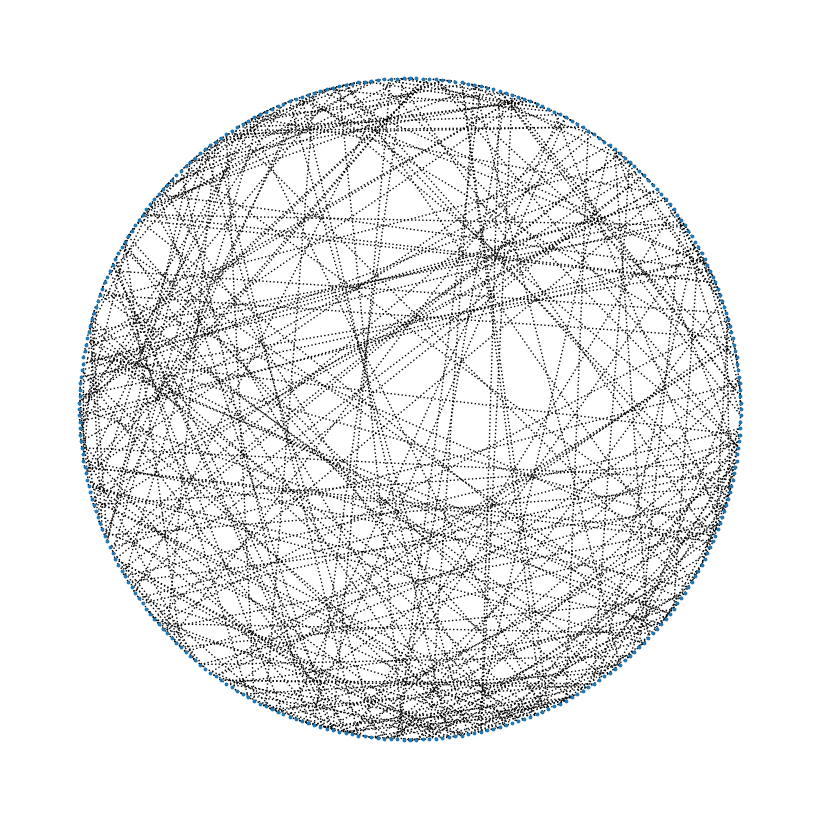

In [5]:
fig = plt.figure(figsize=(8, 8))
nx.draw_circular(G, node_size=3, width=1, style=":")

## Max-Cut Qubo Formulation 
Let $x_i\in\left\{0,1\right\}$ indicate node $i$ is in partition 1 ($x_i=0$) or partition 2 ($x_i=1$). Then 
$$
x_i+x_j-2x_ix_j
$$
will equal 1 if either $x_i$ or $x_j$ exclusively equal 1, but 0 if the are the same. Iterating over all edges in the graph, we set the coefficients to the negative of these values in order to maximize the objective.

In [6]:
# Create a Hamiltonian Operator
n = len(G.nodes)
Q = np.zeros((n, n))
for u, v in G.edges:
    Q[u, v] += 1
    Q[v, u] += 1
    Q[u, u] -= 1
    Q[v, v] -= 1

In [7]:
client = qc.QciClient() # connection configured through environment variables
file_def = {"file_name": "max-cut-mc320-003", "file_config": {"qubo": {"data": Q}}}
file_id = client.upload_file(file_def)["file_id"]

In [8]:
job_body = client.build_job_body(job_type="sample-qubo", qubo_file_id=file_id,
                                 job_params={"sampler_type": "dirac-1", "nsamples": 15})
job_response = client.process_job(job_body=job_body, job_type="sample-qubo")

Dirac allocation balance = 0 s (unmetered)
Job submitted job_id='65e09a951e7c62f8229018a3'-: 2024/02/29 07:54:13
RUNNING: 2024/02/29 07:54:15
COMPLETED: 2024/02/29 07:54:28
Dirac allocation balance = 0 s (unmetered)


A new graph is constructed from the nodes of the original graph, then edges added only if the solution provided has the nodes in the same sets. When the nodes are in different sets, the edge is cut, increasing the cut size by 1

In [9]:
cut_size = 0
Gprime = nx.Graph()
Gprime.add_nodes_from(G.nodes)
results = get_results(job_response)
sample = results["solutions"][0]
for u, v in G.edges:
    if sample[u] != sample[v]:
        cut_size += 1
    else:
        Gprime.add_edge(u, v)
print("Cut", cut_size, "out of", max_cuts, "which is {:.1%} off of optimal".format((max_cuts-cut_size) / max_cuts))

Cut 420 out of 441 which is 4.8% off of optimal


This is the figure described earlier, with all edges between a pair of nodes in the same set.

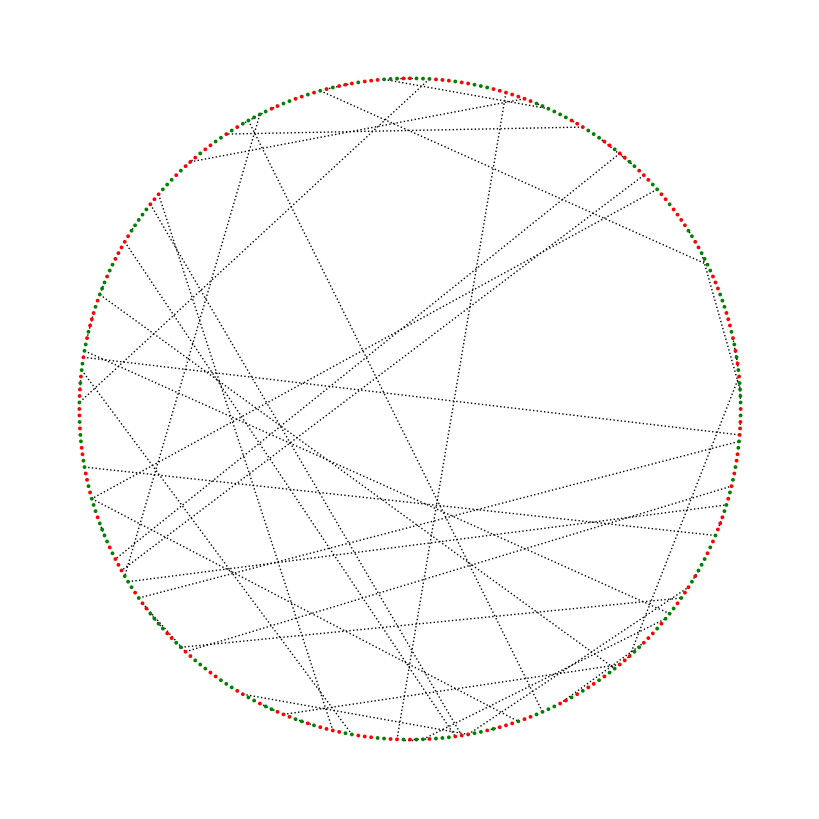

In [10]:
binary_sample = [int((sample[u] + 1) / 2) for u in G.nodes]
color_choices = ["red", "green"]
node_colors = [color_choices[u] for u in binary_sample]
fig = plt.figure(figsize=(8, 8))
nx.draw_circular(Gprime, node_color=node_colors, node_size=3, width=1, style=":")